In [1]:
import os
import sys
import time
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
from datetime import datetime
from model_settings import ms
root = Path().resolve().parent.parent
models_dir = os.path.join(root,ms.trained_models)
train_start = time.time()
train_start_datetime = datetime.fromtimestamp(train_start)
train_start_tag = train_start_datetime.strftime('%c')
print("\n"+"#"*18+"\n# training start #\n"+
      "#"*18+"\n"+f"\n{train_start_tag}\n")

from convsklearn import barrier_trainer, asian_trainer
from feature_collector import collect_features, preprocess_data
price_name = 'barrier_price' 
trainer = barrier_trainer
data_dir = os.path.join(root,ms.cboe_spx_barriers['dump'])
dataset = collect_features(data_dir,price_name)
dates = dataset['date'].copy().squeeze().drop_duplicates().reset_index(drop=True)
dates


##################
# training start #
##################

Sat Nov  2 17:29:37 2024



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3451/3451 [00:45<00:00, 76.11it/s]


0     2024-10-16
1     2024-10-15
2     2024-10-14
3     2024-10-12
4     2024-10-11
         ...    
208   2024-01-23
209   2024-01-22
210   2024-01-20
211   2024-01-19
212   2024-01-18
Name: date, Length: 213, dtype: datetime64[ns]

54 159


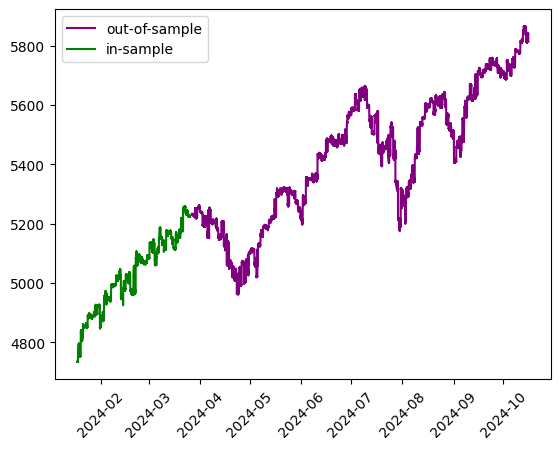

In [2]:
development_dates = dates.iloc[-len(dates)//4:]
test_dates = dates[~dates.isin(development_dates)]
print(len(development_dates),len(test_dates))
preprocessed = preprocess_data(dataset,development_dates,test_dates,trainer)
preprocessor = preprocessed['preprocessor']
test_data = preprocessed['test_data']
train_data = preprocessed['train_data']
train_test = preprocessed['train_test_arrays']
train_X = train_test['train_X']
train_y = train_test['train_y']
test_X = train_test['test_X']
test_y = train_test['test_y']

## stacked regressor

In [3]:
from sklearn.ensemble import StackingRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, QuantileTransformer, PowerTransformer,FunctionTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
trainer.dnn_params

{'alpha': 0.01,
 'hidden_layer_sizes': (13, 13),
 'learning_rate': 'adaptive',
 'learning_rate_init': 0.1,
 'solver': 'sgd',
 'early_stopping': False,
 'max_iter': 500,
 'warm_start': True,
 'tol': 0.0001}

In [4]:
numerical_scaler = StandardScaler()
linear_contributors = [
    'spot_price', 'strike_price', 'days_to_maturity', 
    'risk_free_rate', 'dividend_rate', 
    # 'barrier',
    'v0',
    # 'theta',
    # 'kappa',
]

ridge_preprocessor = ColumnTransformer(
    transformers=[('scaling', numerical_scaler,linear_contributors)]
)
test_ridge_pipeline = make_pipeline(ridge_preprocessor, Ridge())


test_ridge = TransformedTargetRegressor(
    regressor=test_ridge_pipeline,
    transformer=numerical_scaler
)

test_ridge_fit = test_ridge.fit(train_X,train_y)

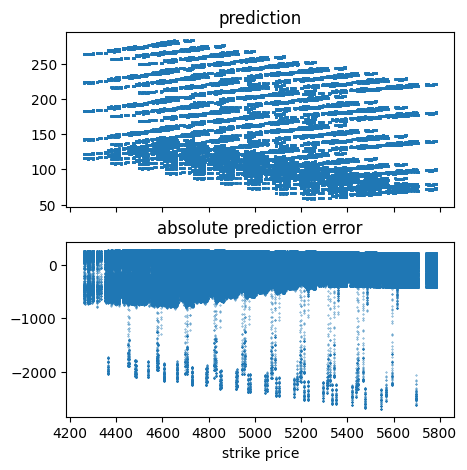


train spots:
calculation_date
2024-01-17 15:50:15.030    4734.50
2024-01-17 16:32:37.613    4734.75
2024-01-17 16:41:02.994    4735.00
2024-01-17 15:50:16.645    4736.50
2024-01-17 15:50:16.645    4737.75
                            ...   
2024-03-25 15:01:52.304    5257.50
2024-03-25 15:46:58.964    5258.00
2024-03-25 15:47:43.868    5258.25
2024-03-25 15:43:55.367    5258.50
2024-03-25 15:44:16.995    5258.75
Name: spot_price, Length: 708, dtype: float64


TransformedTargetRegressor(regressor=Pipeline(steps=[('columntransformer',
                                                      ColumnTransformer(transformers=[('scaling',
                                                                                       StandardScaler(),
                                                                                       ['spot_price',
                                                                                        'strike_price',
                                                                                        'days_to_maturity',
                                                                                        'risk_free_rate',
                                                                                        'dividend_rate',
                                                                                        'v0'])])),
                                                     ('ridge', Ridge())]),
                           transformer=StandardScaler())

In [5]:
K = train_X['strike_price'].squeeze().reset_index(drop=True).to_numpy()

predictions = test_ridge_fit.predict(train_X)
diff = predictions-train_y
fig,axs = plt.subplots(2,figsize=(5,5),sharex=True)
axs[0].scatter(K,predictions,s=0.1)
axs[0].set_title('prediction')
axs[1].scatter(K,diff,s=0.1)
axs[1].set_title('absolute prediction error')
plt.xlabel('strike price')
plt.show()
spots = train_data['spot_price'].copy().squeeze().sort_values().reset_index(drop=True)
spots.index = train_data['calculation_date']
print(f"\ntrain spots:\n{spots.drop_duplicates()}")
test_ridge

In [6]:
mlp_pipeline = make_pipeline(preprocessor,MLPRegressor(**trainer.dnn_params))

ridge_pipeline = make_pipeline(ridge_preprocessor, Ridge())

stacked_regressor = StackingRegressor(
    estimators=[
        ('ridge',ridge_pipeline),
        ('dnn',mlp_pipeline)
    ],
    final_estimator=GradientBoostingRegressor()
)
meta = TransformedTargetRegressor(regressor=stacked_regressor,transformer=numerical_scaler)
meta

TransformedTargetRegressor(regressor=StackingRegressor(estimators=[('ridge',
                                                                    Pipeline(steps=[('columntransformer',
                                                                                     ColumnTransformer(transformers=[('scaling',
                                                                                                                      StandardScaler(),
                                                                                                                      ['spot_price',
                                                                                                                       'strike_price',
                                                                                                                       'days_to_maturity',
                                                                                                                       'risk_free_rate',
                                                                                                                       'dividend_rate',
                                                                                                                       'v0'])])),
                                                                                    ('ridge',
                                                                                     Ridge())])),
                                                                   ('dnn',
                                                                    Pipeline(steps=[('columntransformer',
                                                                                     ColumnTransformer(tra...
                                                                                                                       'theta',
                                                                                                                       'rho',
                                                                                                                       'eta',
                                                                                                                       'v0',
                                                                                                                       'barrier']),
                                                                                                                     ('OneHotEncoder',
                                                                                                                      OneHotEncoder(sparse_output=False),
                                                                                                                      ['barrier_type_name',
                                                                                                                       'w'])])),
                                                                                    ('mlpregressor',
                                                                                     MLPRegressor(alpha=0.01,
                                                                                                  hidden_layer_sizes=(13,
                                                                                                                      13),
                                                                                                  learning_rate='adaptive',
                                                                                                  learning_rate_init=0.1,
                                                                                                  max_iter=500,
                                                                                                  solver='sgd',
                                                                                                  warm_start=True))]))],
                 

In [7]:
meta.fit(train_X,train_y)
P = meta.predict(train_X)
diff = train_y - P
RMSE = np.sqrt(np.mean(diff**2))
MAE = np.mean(np.abs(diff))
end = time.time()
runtime = end-train_start
print(f"cpu: {runtime}")
print(f"\n\nMAE: {MAE}\nRMSE: {RMSE}")

cpu: 2125.9864826202393


MAE: 21.70372623444954
RMSE: 35.60009658391894


In [8]:
testP = meta.predict(test_X)
diff = test_y - testP
RMSE = np.sqrt(np.mean(diff**2))
MAE = np.mean(np.abs(diff))
print(f"MAE: {MAE}\nRMSE: {RMSE}")

MAE: 37.70771379493719
RMSE: 74.14334367251043


### versus original

In [9]:
dnn = barrier_trainer.run_dnn(preprocessor, train_X, train_y)
P = dnn.predict(train_X)
diff = train_y - P
RMSE = np.sqrt(np.mean(diff**2))
MAE = np.mean(np.abs(diff))
print(f"\n\nin sample:\nMAE: {MAE}\nRMSE: {RMSE}")


training...

alpha: 0.01
hidden_layer_sizes: (13, 13)
learning_rate: adaptive
learning_rate_init: 0.1
solver: sgd
early_stopping: False
max_iter: 500
warm_start: True
tol: 0.0001
cpu: 363.7352488040924


in sample:
MAE: 16.727917066682654
RMSE: 25.6600520210659


In [10]:
testP = dnn.predict(test_X)
diff = test_y - testP
RMSE = np.sqrt(np.mean(diff**2))
MAE = np.mean(np.abs(diff))
print(f"MAE: {MAE}\nRMSE: {RMSE}")

MAE: 31.587967411970023
RMSE: 68.04113560261004


In [11]:
train_data.describe()

,spot_price,strike_price,barrier,days_to_maturity,rebate,dividend_rate,risk_free_rate,theta,kappa,rho,eta,v0,calculation_date,date,barrier_price,observed_price
count,1.924426e+06,1.924426e+06,1.924426e+06,1.924426e+06,1924426.0,1924426.0,1.924426e+06,1.924426e+06,1.924426e+06,1.924426e+06,1.924426e+06,1.924426e+06,1924426,1924426,1.924426e+06,1.924426e+06
mean,5.032001e+03,5.030690e+03,5.068574e+03,3.290221e+02,0.0,0.0,4.000000e-02,7.375994e-02,1.699258e+01,-4.607487e-01,2.574505e+00,1.052645e-02,2024-02-20 19:19:28.836888064,2024-02-21 02:59:12.578067200,1.573653e+02,1.573658e+02
min,4.734500e+03,4.261050e+03,2.367250e+03,6.000000e+01,0.0,0.0,4.000000e-02,1.533654e-02,1.996711e-03,-6.771834e-01,1.005026e+00,3.401120e-12,2024-01-17 15:50:15.030000,2024-01-18 00:00:00,0.000000e+00,1.000014e-02
25%,4.942500e+03,4.745250e+03,3.783669e+03,9.000000e+01,0.0,0.0,4.000000e-02,2.535151e-02,4.027612e+00,-5.041714e-01,1.549609e+00,5.108037e-03,2024-02-02 16:17:06.065999872,2024-02-03 00:00:00,8.416975e+00,8.416619e+00
50%,5.030000e+03,5.022756e+03,5.054693e+03,3.600000e+02,0.0,0.0,4.000000e-02,2.915340e-02,7.676142e+00,-4.622611e-01,2.033796e+00,1.146955e-02,2024-02-21 15:35:18.425999872,2024-02-22 00:00:00,7.071644e+01,7.071579e+01
75%,5.132000e+03,5.313994e+03,6.373831e+03,5.400000e+02,0.0,0.0,4.000000e-02,3.519672e-02,2.573380e+01,-4.203454e-01,3.405124e+00,1.587106e-02,2024-03-08 15:05:42.910000128,2024-03-09 00:00:00,2.373224e+02,2.373189e+02
max,5.258750e+03,5.784625e+03,7.888125e+03,7.200000e+02,0.0,0.0,4.000000e-02,1.736060e+01,1.941193e+02,-2.442782e-01,9.122050e+00,2.864645e-02,2024-03-25 15:50:19.451000,2024-03-26 00:00:00,2.767157e+03,2.767164e+03
std,1.215358e+02,3.464835e+02,1.556015e+03,2.417047e+02,0.0,0.0,1.040834e-16,7.296202e-01,2.000055e+01,6.751744e-02,1.380978e+00,7.193085e-03,NaN,NaN,2.125623e+02,2.125619e+02
